In [1]:
import numpy as np
import h5py
import os
from tqdm.notebook import tqdm
import copy
import matplotlib.pyplot as plt
from pde import MemoryStorage

from methods.base import BaseConfig
from methods.plotting import plot_perm, plot_press, plot_cumulative_events_projection, plot_event_list
from methods.pore_press_calc_functions import Pore_Press_Diffusion_with_Source_and_Gravity, test_wells, get_q_factors
from methods.seism_calc_functions import Micro_Seismic_Seeds, get_litostat_pressure, get_stress, \
    get_norm_and_shear_stress_on_seeds, check_colomb_criteria, get_raw_events, resample_raw_events, get_events, get_events_list

# from datetime import datetime
# target_path = f'target_{datetime.now().strftime("%m_%d_%Y__%H_%M_%S")}.h5'


In [2]:
# setup base params and eq
params = BaseConfig(
            sources = [{'loc':(2000, 2000, 1500), 'Q':np.array([1, 1]), 'P': 0.2}, # P - target overpressue relative to max pressure in sources (if p0=0.1 MPa, P=-0.05 => abs pressure = 0.1 - 0.05 = 0.05 MPa)
                       {'loc':(500, 500, 1500), 'Q':np.array([-0.25, -0.25]), 'P': -0.05},
                       {'loc':(3500, 500, 1500), 'Q':np.array([-0.25, -0.25]), 'P': -0.05},
                       {'loc':(3500, 3500, 1500), 'Q':np.array([-0.25, -0.25]), 'P': -0.05},
                       {'loc':(500, 3500, 1500), 'Q':np.array([-0.25, -0.25]), 'P': -0.05},],
            time_scale = 3600, 
            t_range = 120,
            NSAMPL = 200,
            )


# eq initial setup
eq = Pore_Press_Diffusion_with_Source_and_Gravity(np.ones(params.shape), params)

In [3]:
# wells testing if needed (it takes about 15 min)
# press_in_locs, interpolators = test_wells(eq, params, k_list=10**np.linspace(-1, 4, 20))

  0%|          | 0/20 [00:00<?, ?it/s]

In [3]:
perms_path = 'downscaled_models_03_05_2024__13_33_23.h5'

with h5py.File(perms_path, 'r') as f:
    nmodels = f['perm'].shape[0]

# idx_list = range(nmodels)
idx_list = [5,]
for ii in tqdm(idx_list):
    
    '''reading data'''

    with h5py.File(perms_path, 'r') as f:
        perm = f['perm'][ii]
        dens = f['dens'][ii]

    '''fluid dyn modeling'''

    eq.xi_field = eq.update_xi_field(perm) # updating permeability field

    p0 = eq.pore_ini_field
    q_factors = get_q_factors(perm, p0, params)
    eq.source_field = eq.update_source_field(0, q_factors) # updating source fields q_new = q * factor
    
    storage = MemoryStorage()
    res = eq.solve(p0, t_range=params.t_range, adaptive=True, tracker=[storage.tracker(1)])
    # res = eq.solve(p0, t_range=params.t_range, adaptive=True, tracker=['progress', 'plot', storage.tracker(1)]) # for testing
    pore_press = np.stack(storage.data, axis=0) # 4d np array

    '''seismic modeling'''

    seeds = Micro_Seismic_Seeds(params) # creating microseismic seeds obj
    tan_phi, C, norms = seeds.tan_phi_rvs, seeds.C_rvs, seeds.norms_rvs

    lithostat_pressure = get_litostat_pressure(params, dens)

    stress = get_stress(params, lithostat_pressure) # litostatic stress tensor based on density model
    sigma_n, tau = get_norm_and_shear_stress_on_seeds(stress, norms) # stresses without pore pressure

    colomb_pass = check_colomb_criteria(params, pore_press, tan_phi, C, sigma_n, tau) # (dim broadcasting) 

    raw_events = get_raw_events(params, colomb_pass) # num of seeds passed in every cell
    events_dens = resample_raw_events(params, raw_events) # event probability (raw_events normalized to target num)
    events = get_events(params, events_dens) # events

    events_list = get_events_list(events) # list of events (time, x, y, d, Mag)

    events_by_time = np.sum(events, axis=(1,2,3)) # events number at every step
    tot_events = np.sum(events)

    '''saving'''
    
    # saving here


  0%|          | 0/1 [00:00<?, ?it/s]

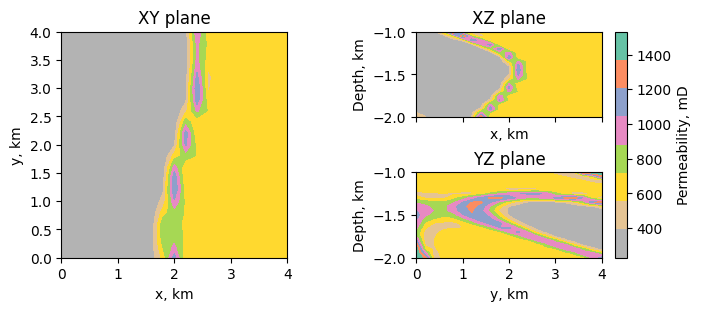

In [4]:
plot_perm(perm, (10, 10, 10), params)

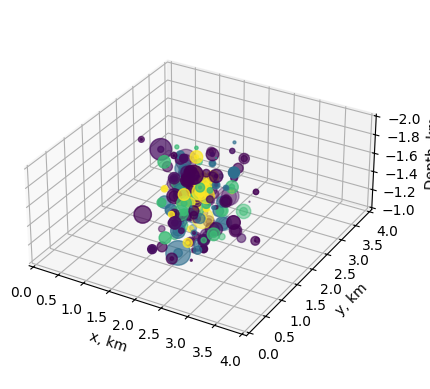

In [13]:
plot_event_list(events_list[0:300], params)

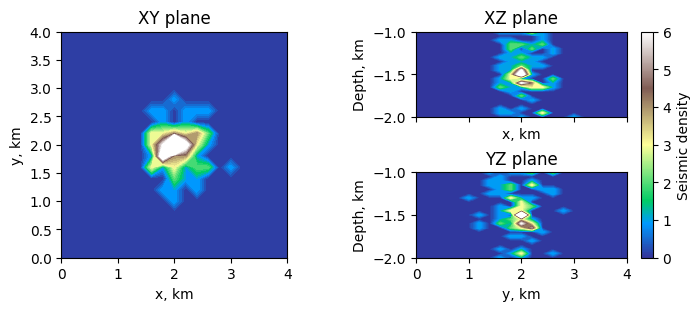

71.0


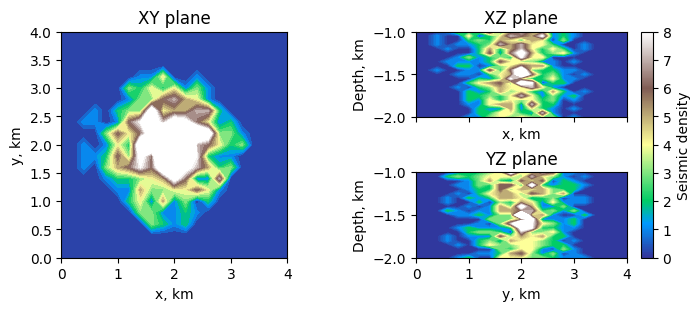

666.0


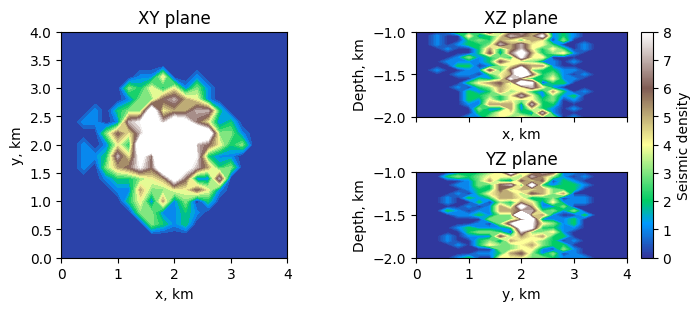

670.0


In [7]:
for ii in [2,50,100]:
    plot_cumulative_events_projection(raw_events, ii, params=params)
    print(np.sum(raw_events[0:ii]))

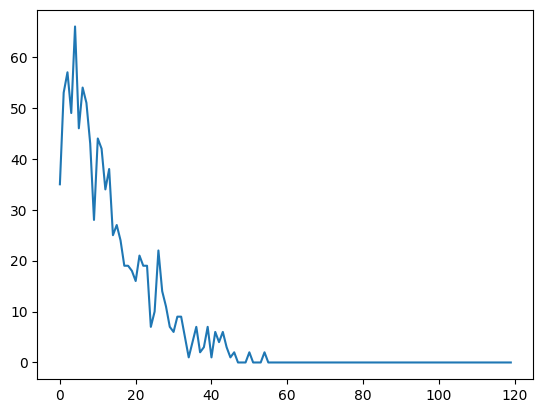

In [9]:
fig, ax = plt.subplots()
ax.plot(events_by_time)

In [18]:
np.max((pore_press[120] - p0).data)

0.1427968976096725